# TASK: Forecasting a week Demand

In [38]:
## Import Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import auto_arima
import warnings

**UPLOAD DATASET**

In [2]:
##Load data
#df = pd.read_excel(r'H:\AkshitaJ\tasks\forecasting task\Forecasting dataset.xlsx')

##Convert to .csv to avoid having to repetedly pull data 
#df.to_csv("Forcasting_data.csv")


Conver to .csv and print the columns

In [3]:
##Load .csv dataset
df = pd.read_csv ("Forecasting_data.csv")
print(df.head())
print(df.shape)
print(df.columns)

   Unnamed: 0            Timestamp   Demand  Generation   Import  Solar  \
0           0  2020-12-01 00:00:00  7620.20      931.99  6693.61  32.56   
1           1  2020-12-01 00:05:00  7735.67      990.75  6749.23  32.35   
2           2  2020-12-01 00:10:00  7771.58      995.03  6779.92  32.45   
3           3  2020-12-01 00:15:00  7792.93      992.68  6802.93  32.39   
4           4  2020-12-01 00:20:00  7749.35      945.33  6807.54  32.45   

     Wind   Other  
0  533.19  353.10  
1  521.96  366.60  
2  511.67  368.03  
3  515.04  366.12  
4  517.15  359.86  
(31680, 8)
Index(['Unnamed: 0', 'Timestamp', 'Demand', 'Generation', 'Import', 'Solar',
       'Wind', 'Other'],
      dtype='object')


In [4]:
# Strip any leading/trailing spaces in the column names
df.columns = df.columns.str.strip()

# Now convert the 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')

# Set the 'Timestamp' column as the index
df.set_index('Timestamp', inplace=True)

**DATA VISUALISATION**

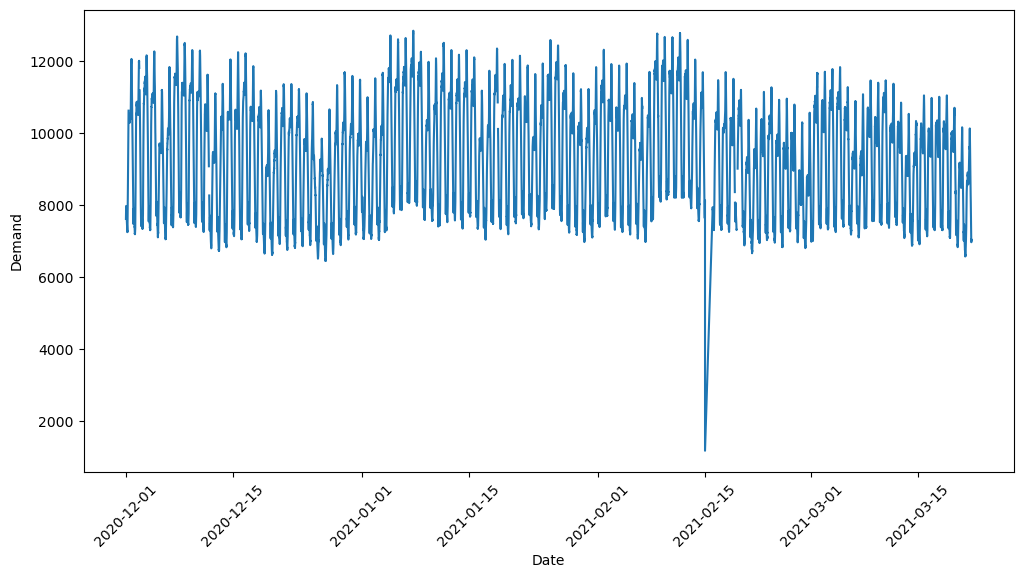

In [5]:
#Plot the time series data
plt.figure(figsize=(12, 6))
plt.ylabel('Demand')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df.index, df['Demand'], )
plt.show()

# DATA CLEANING

**REMOVING OUTLIERS**

In [8]:
#The dataset has one outlier at 2021-02-15
df_outlier = df['Demand'].min()
print("demand_outlier:",df_outlier)


#drop the outlier
df.drop(df[df['Demand']== 1168.88].index, inplace = True)  #remove min

demand_outlier: 1168.88


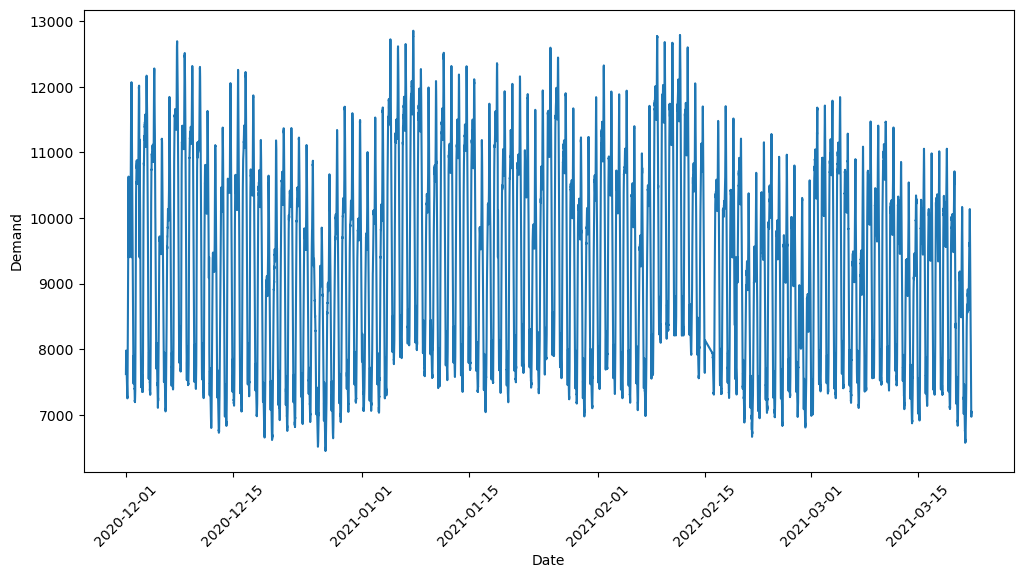

In [9]:
#Plot the demand timeseries again
plt.figure(figsize=(12, 6))
plt.ylabel('Demand')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df.index, df['Demand'], )
plt.show()

**MISSING VALUES**

- Although previously removed by strip. Check if there are any missing values. 

Missing values in demand column: 0
Checking the Missing values in demand column: 0


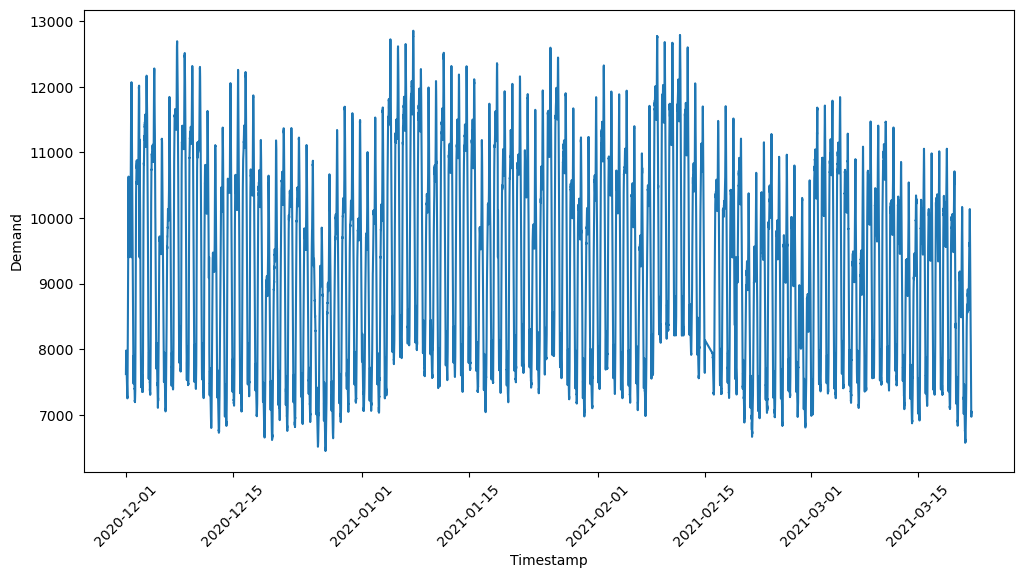

In [10]:
#Check the total missing values in column 'Demand' 
print ("Missing values in demand column:", df['Demand'].isnull().sum())

# Replace the missing values by median
median = df['Demand'].median()
df['Demand'] = df['Demand'].fillna(median)
print ("Checking the Missing values in demand column:", df['Demand'].isnull().sum())

#Now, plot the time series data
plt.figure(figsize=(12, 6))
plt.ylabel('Demand')
plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.plot(df.index, df['Demand'], )
plt.show()

**LOG TRANSFORMATION**

Missing values in date column: 0


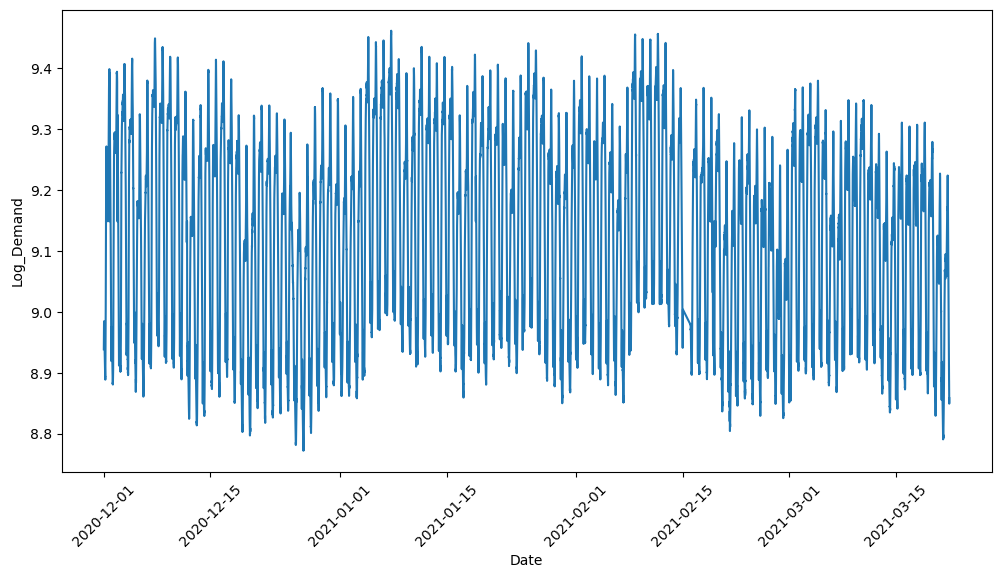

In [11]:
#Check missing values in column 'Date'
print ("Missing values in date column:",df.index.isnull().sum())

## Apply log transformation
df['Log_Demand'] = np.log(df['Demand'])

# Now, plot the log-transformed time series data
plt.figure(figsize=(12, 6))
plt.ylabel('Log_Demand')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df.index, df['Log_Demand'], ) 
plt.show()

**GROUPBY**

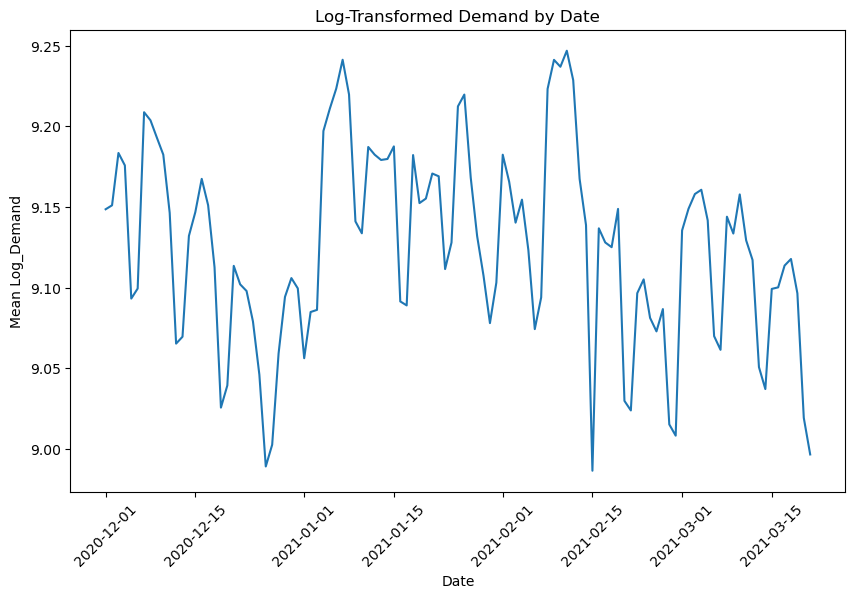

In [12]:
# Group by day and calculate the mean of the log-transformed demand
Demand_by_date = df.groupby(df.index.date).mean()

# Plot the grouped log-transformed data by day
plt.figure(figsize=(10, 6))
plt.ylabel('Mean Log_Demand')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(Demand_by_date.index, Demand_by_date['Log_Demand'])
plt.title('Log-Transformed Demand by Date')
plt.show()

**STATIONARITY**
- To check if the data is stationary. 
- This is important to quantify any trends, seasonal variations, or cycle in the data.
- Stationary data is then used for forecasting when using ARIMAX model.

In [13]:
#The data is stationary if the mean and variance are constant over time.
#Check the stationarity of the data using Augmented Dickey-Fuller (ADF) test 

# Function to perform ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Reject the null hypothesis - Data is stationary")
    else:
        print("Fail to reject the null hypothesis - Data is non-stationary")

# Drop rows with missing values in 'Demand' and 'Log_Demand' columns
df_clean = df.dropna(subset=['Demand', 'Log_Demand'])

# ADF test for the cleaned original demand data
print("\nADF Test for Original Demand Data:")
adf_test(df_clean['Demand'])

# ADF test for the cleaned log-transformed demand data
print("\nADF Test for Log-Transformed Demand Data:")
adf_test(df_clean['Log_Demand'])

# ADF test for the cleaned grouped data by date
print("\nADF Test for Grouped Data by Date:")
adf_test(Demand_by_date['Log_Demand'])


ADF Test for Original Demand Data:
ADF Statistic: -19.089193558781417
p-value: 0.0
Critical Values: {'1%': -3.4305567669162755, '5%': -2.8616313855608624, '10%': -2.566818641715227}
Reject the null hypothesis - Data is stationary

ADF Test for Log-Transformed Demand Data:
ADF Statistic: -19.24486724994373
p-value: 0.0
Critical Values: {'1%': -3.4305567734542706, '5%': -2.8616313884503843, '10%': -2.5668186432532476}
Reject the null hypothesis - Data is stationary

ADF Test for Grouped Data by Date:
ADF Statistic: -3.1661405833495597
p-value: 0.02203017215873434
Critical Values: {'1%': -3.4961490537199116, '5%': -2.8903209639580556, '10%': -2.5821223452518263}
Reject the null hypothesis - Data is stationary


**This means the data is stationary at all levels!**

# SPLIT THE DATA
- The data is split into train and test. 
- Train is the past data that is used by the model to make predictions. 
- Test is the unseen data used by the model to test the predictions (should be atleast the same size as the predictions). 

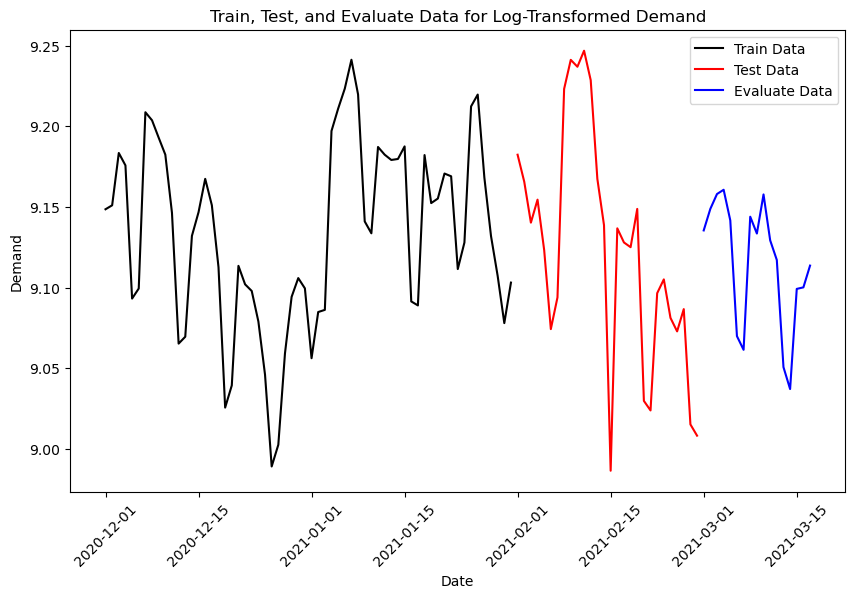

In [45]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Split the data into training, testing, and evaluation sets based on date
train_split_date = '2021-02-01'
test_split_date = '2021-03-01'
eval_split_date = '2021-03-17'

train = Demand_by_date[Demand_by_date.index < pd.to_datetime(train_split_date)]
test = Demand_by_date[(Demand_by_date.index >= pd.to_datetime(train_split_date)) & (Demand_by_date.index < pd.to_datetime(test_split_date))]
evaluate = Demand_by_date[(Demand_by_date.index >= pd.to_datetime(test_split_date)) & (Demand_by_date.index <= pd.to_datetime(eval_split_date))]

# Plot the train, test, and evaluation data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Log_Demand'], label='Train Data', color='black')
plt.plot(test.index, test['Log_Demand'], label='Test Data', color='red')
plt.plot(evaluate.index, evaluate['Log_Demand'], label='Evaluate Data', color='blue')
plt.title('Train, Test, and Evaluate Data for Log-Transformed Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ARIMA MODEL


The ARIMA model (Autoregressive Integrated Moving Average) has three main parameters: p, d, and q. These parameters control different aspects of the model and help in fitting the time series data accurately.
1. p (Autoregressive Order):
 - This parameter refers to the number of autoregressive (AR) terms. 
 - The AR term captures the correlation between the current value and its previous values.
 - A higher value of p indicates that more past observations are being used in the model to predict future values.
2. d (Degree of Differencing):
 - This parameter refers to the number of differencing operations needed to make the time series stationary.
 - Differencing is used to remove trends in the data. If the data shows an upward or downward trend, applying differencing can   help stabilize the mean of the time series by removing these trends.
 - The d value represents how many times the series has been differenced. For example:
          d = 0: No differencing (the series is already stationary).
          d = 1: The series has been differenced once.
          d = 2: The series has been differenced twice.

3. q (Moving Average Order):
 - This parameter refers to the number of moving average (MA) terms.
 - A moving average model captures the relationship between the residual errors and past forecast errors. In simple terms, it accounts for the lagged errors in the forecast.
 - A higher value of q means the model uses more lagged forecast errors to make predictions.

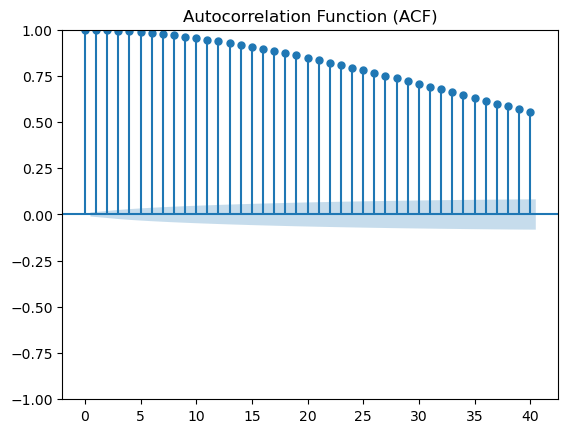

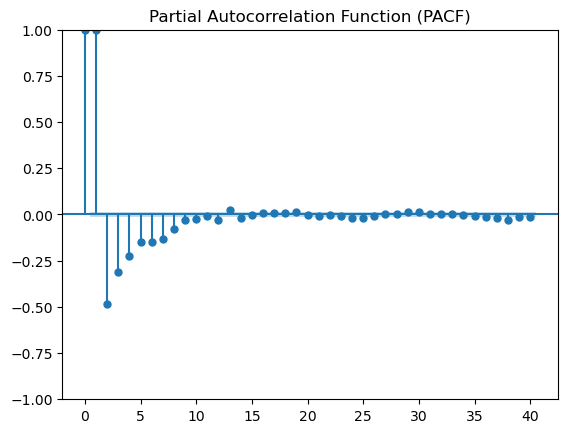

In [46]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# If data is not stationary, take first difference to make it stationary
# Check for stationarity visually or using statistical tests like the Augmented Dickey-Fuller test

# Plot ACF and PACF
plot_acf(df['Log_Demand'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF (for estimating p)
plot_pacf(df['Log_Demand'],lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

ARIMA(1,1,1) - MSE: 0.005342614432064822
ARIMA(1,1,2) - MSE: 0.005314176076182553
ARIMA(1,1,3) - MSE: 0.0053140247658343045
ARIMA(1,1,4) - MSE: 0.005089234129618057
ARIMA(1,1,5) - MSE: 0.006204811226484685
ARIMA(1,1,6) - MSE: 0.005292272730584329
ARIMA(1,1,7) - MSE: 0.005464624690106374
ARIMA(1,1,8) - MSE: 0.005723904133810751
ARIMA(2,1,1) - MSE: 0.005115916571789185
ARIMA(2,1,2) - MSE: 0.005137483896557359
ARIMA(2,1,3) - MSE: 0.005238769723279244
ARIMA(2,1,4) - MSE: 0.005241804659014637
ARIMA(2,1,5) - MSE: 0.005197577749873475
ARIMA(2,1,6) - MSE: 0.005238166203133246
ARIMA(2,1,7) - MSE: 0.005252522528911113
ARIMA(2,1,8) - MSE: 0.00526431016853635
ARIMA(3,1,1) - MSE: 0.005361442881834054
ARIMA(3,1,2) - MSE: 0.005172414664214424
ARIMA(3,1,3) - MSE: 0.0049048211722696345
ARIMA(3,1,4) - MSE: 0.005806240203975315
ARIMA(3,1,5) - MSE: 0.005237958193912386
ARIMA(3,1,6) - MSE: 0.005668251106166312
ARIMA(3,1,7) - MSE: 0.0049113910857077284
ARIMA(3,1,8) - MSE: 0.005708011225654959
ARIMA(4,1,1) -

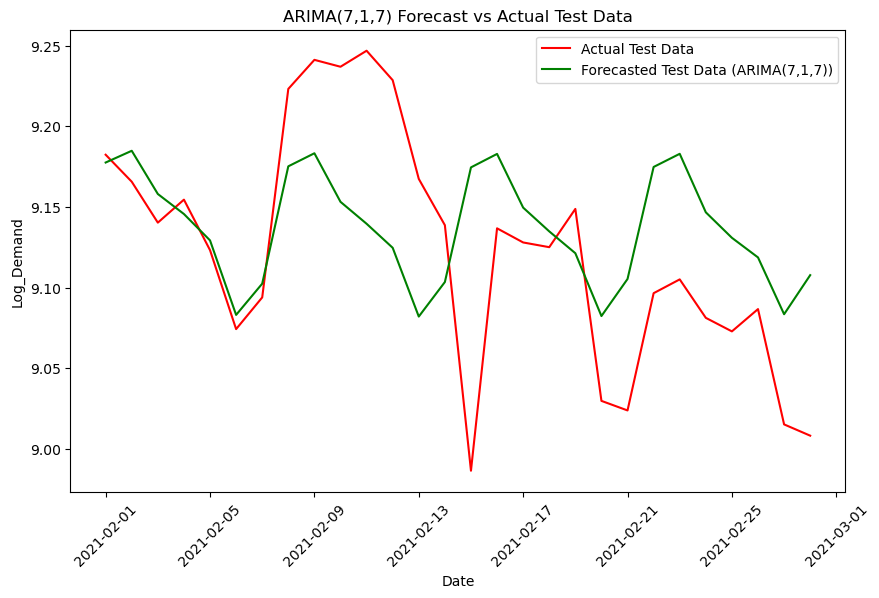

In [44]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Find the best combinations of ARIMA parameters (p and q as d = 1)

# Initialize variables to store the best p, q, and corresponding error
best_p, best_q, best_d = None, None, None
best_mse = float("inf")
best_forecast = None

# 2. Range of values for p and q
p_values = range(1, 9)
q_values = range(1, 9)

# 3. Loop through all combinations of p and q
for p in p_values:
    for q in q_values:
        try:
            # Fit ARIMA model with order (p, d, q)
            model = ARIMA(train['Log_Demand'], order=(p, 1, q))
            model_fit = model.fit()

            # Forecast on the test data
            test_forecast = model_fit.forecast(steps=len(test))

            # Calculate MSE
            mse = mean_squared_error(test['Log_Demand'], test_forecast)

            # Check if this is the best model so far
            if mse < best_mse:
                best_p, best_q = p, q
                best_mse = mse
                best_forecast = test_forecast

            print(f'ARIMA({p},1,{q}) - MSE: {mse}')
        except Exception as e:
            print(f'ARIMA({p},1,{q}) failed: {e}')

# 4. Print the best combination of p and q
print(f'Best ARIMA({best_p},1,{best_q}) - MSE: {best_mse}')

# 5. Plot the best forecast vs actual test data
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Log_Demand'], label='Actual Test Data', color='red')
plt.plot(test.index, best_forecast, label=f'Forecasted Test Data (ARIMA({best_p},1,{best_q}))', color='green')
plt.title(f'ARIMA({best_p},1,{best_q}) Forecast vs Actual Test Data')
plt.xlabel('Date')
plt.ylabel('Log_Demand')
plt.xticks(rotation=45)
plt.legend()
plt.show()

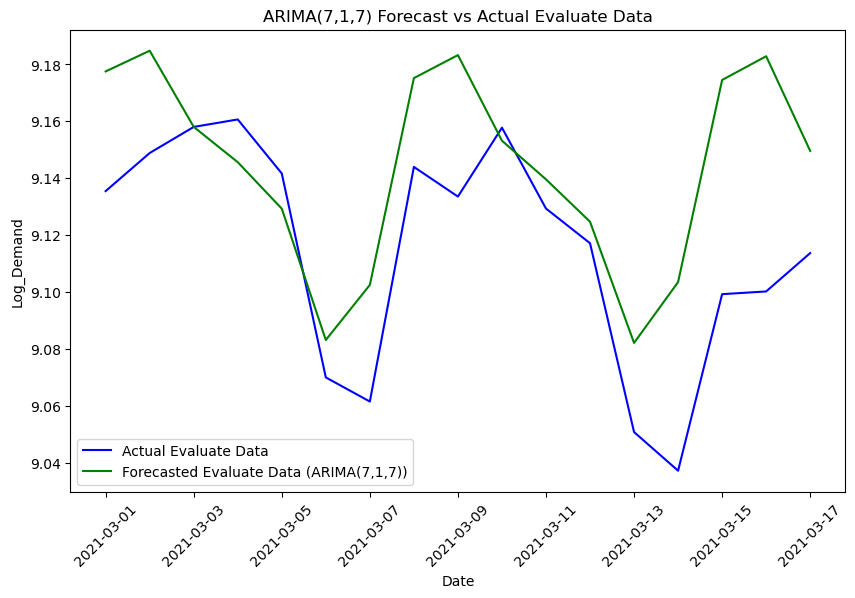

In [47]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Fit the ARIMA model using the best p, d, q values
best_model = ARIMA(train['Log_Demand'], order=(best_p, 1, best_q))
best_model_fit = best_model.fit()

# Forecast on the evaluation data (forecast from the end of the test set)
eval_forecast = best_model_fit.forecast(steps=len(evaluate))

# Plot the forecast vs actual evaluation data
plt.figure(figsize=(10, 6))
plt.plot(evaluate.index, evaluate['Log_Demand'], label='Actual Evaluate Data', color='blue')
plt.plot(evaluate.index, eval_forecast, label=f'Forecasted Evaluate Data (ARIMA({best_p},1,{best_q}))', color='green')
plt.title(f'ARIMA({best_p},1,{best_q}) Forecast vs Actual Evaluate Data')
plt.xlabel('Date')
plt.ylabel('Log_Demand')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**MODEL EVALUATION**
- Performed using root mean squared error test. 
- It represents the square root of the average of the squared differences between the actual values and the predicted values.

In [48]:
# 6. Evaluate the model performance using RMSE on evaluation data
rmse_eval = np.sqrt(mean_squared_error(evaluate['Log_Demand'], eval_forecast))
print(f'RMSE on Evaluate Data: {rmse_eval}')

RMSE on Evaluate Data: 0.040668594542400946


Therefore, the model is not doing so well. 

## XGBOOST (Extreme Gradient Boosting) MODEL

**Key concept:**
- The decision tree finds the best fit to the data based learning from previous fits. 
- Gradient Boosting combines weak decision trees to create strong learners, by correcting the errors made by previous ones. 
- It is smart, fast, and make reliable predictions. 

**Boosting Process:**
- The model starts with an inital prediction (like mean of the target data point)
- It computes residuals of the predictions
- A new tree is trained to predict these residuals and fit the best prediction by iteration. 

**Prevention of overfits:**
- The XGBoost uses Lasso and Ridge regularisation 
- Lasso shrinks the coefficients to zero which helps to identify only the most important features. 
- Ridge shrinks the coefficients towards zero so instead of removing the features completely, it minimises the effect. 

The final model prediction is the sum of the predictions from all tree. 

In [53]:
# !pip install xgboost

In [54]:
import xgboost as xgb

In [76]:
# Create lag features for training data
train_lagged = create_lagged_features(train.copy(), lag_values)

# Prepare the training data by splitting
# X_train contains the input data the model will use to make predictions.
# y_train contains the actual outcomes the model aims to predict.
X_train = train_lagged.drop(columns=['Log_Demand'])
y_train = train_lagged['Log_Demand']

# Initialise the model. 
# XGBRegressor has some parameters : 
# Objective minimises the squared errors.
# n_estimators are the number of trees to be built.
# learning_rate tells how much each tree can contribute to predictions.
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [77]:
# Prepare the test data with lag features
test_lagged = create_lagged_features(test.copy(), lag_values)

# Ensure we have enough lagged data for predictions
test_lagged.dropna(inplace=True)

# Split the test features and target variable
# Allows for comparison between predicted and actual outcomes to evaluate model performance
X_test = test_lagged.drop(columns=['Log_Demand'])
y_test = test_lagged['Log_Demand']

y_test shape: (25,)
predictions shape: (25,)


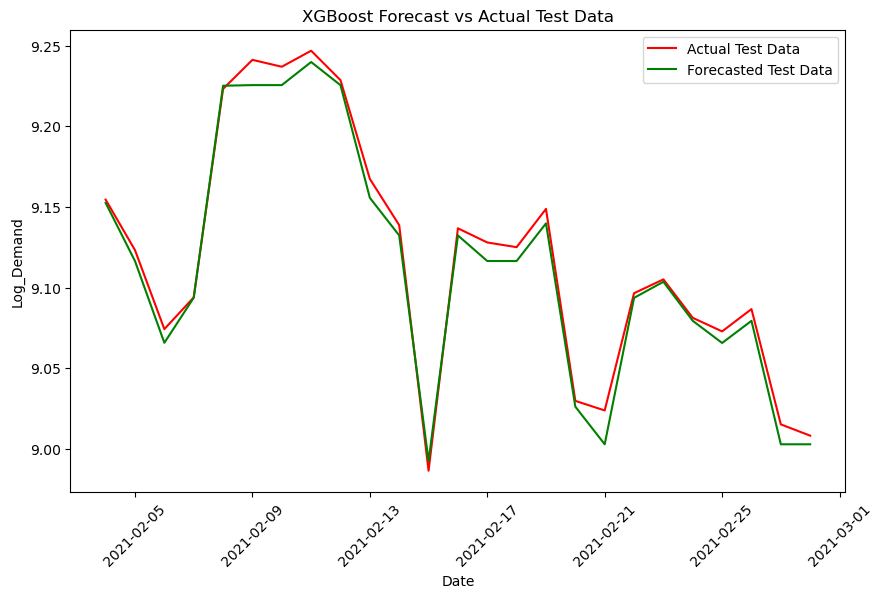

In [87]:
# Make predictions
predictions = model.predict(X_test)

# Check dimensions
print(f'y_test shape: {y_test.shape}')
print(f'predictions shape: {predictions.shape}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test.index[-len(y_test):], y_test, label='Actual Test Data', color='red')  # Adjusting the index
plt.plot(test.index[-len(predictions):], predictions, label='Forecasted Test Data', color='green')  # Adjusting the index
plt.title('XGBoost Forecast vs Actual Test Data')
plt.xlabel('Date')
plt.ylabel('Log_Demand')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [88]:
# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print(f'XGBoost Model MSE: {mse}')

XGBoost Model MSE: 7.319816422583885e-05


**Forecasting demand**

XGBoost Model Evaluation MSE: 3.186805058801896e-05


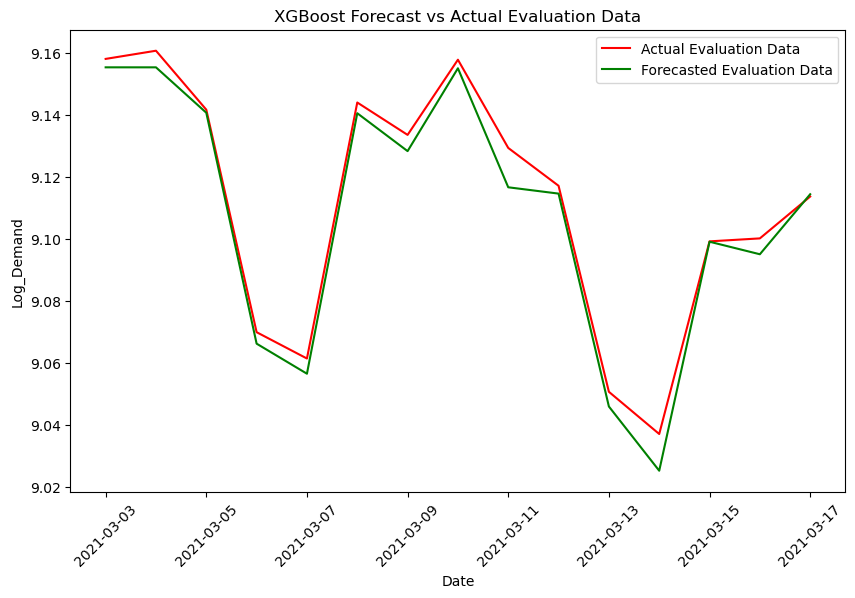

In [97]:
#Ignore warnings
warnings.filterwarnings("ignore")

# Create lag features for training data
train_lagged = create_lagged_features(train.copy(), lag_values)
train_lagged.dropna(inplace=True)

# Prepare the training data
X_train = train_lagged.drop(columns=['Log_Demand'])
y_train = train_lagged['Log_Demand']

# Train the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Prepare the evaluation data with lag features
eval_lagged = create_lagged_features(evaluate.copy(), lag_values)
eval_lagged.dropna(inplace=True)

# Prepare the evaluation features and target variable
X_eval = eval_lagged.drop(columns=['Log_Demand'], errors='ignore')
y_eval = eval_lagged['Log_Demand']

# Make predictions on the evaluation data
predictions_eval = model.predict(X_eval)

# Evaluate MSE for evaluation data
mse_eval = mean_squared_error(y_eval, predictions_eval)
print(f'XGBoost Model Evaluation MSE: {mse_eval}')

# Plot the results for evaluation data
plt.figure(figsize=(10, 6))
plt.plot(evaluate.index[-len(y_eval):], y_eval, label='Actual Evaluation Data', color='red')
plt.plot(evaluate.index[-len(predictions_eval):], predictions_eval, label='Forecasted Evaluation Data', color='green')
plt.title('XGBoost Forecast vs Actual Evaluation Data')
plt.xlabel('Date')
plt.ylabel('Log_Demand')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Therefore, the XGBoost model successfully captures the features of demand and give accurate predictions. 